In [1]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/machine_learning/Exam_Project

Mounted at /content/gdrive
/content/gdrive/MyDrive/machine_learning/Exam_Project


In [3]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torchtext
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

import import_ipynb
import utils

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)

importing Jupyter notebook from utils.ipynb


In [4]:
speech = pd.read_csv("./cleaned_speeches.csv")
speech.head()

,Date,President,Party,Title,Transcript
0,1829-03-04,Andrew Jackson,0,First Inaugural Address,Fellow Citizens: About to undertake the arduou...
1,1829-05-11,Andrew Jackson,0,Proclamation Regarding Duties on Austrian Vessels,Whereas by an act of the Congress of the Unite...
2,1829-12-08,Andrew Jackson,0,First Annual Message to Congress,Fellow citizens of the Senate and House of Rep...
3,1830-05-06,Andrew Jackson,0,Message Regarding Treaties with the Choctaw Na...,To the Senate of the United States. The accomp...
4,1830-05-27,Andrew Jackson,0,Veto Message Regarding Funding of Infrastructu...,To the House of Representatives. I have mature...


In [5]:
from keras.preprocessing.text import Tokenizer

In [6]:
t  = Tokenizer()

In [7]:
t.fit_on_texts(speech.Transcript)

In [8]:
print("The document count",t.document_count)

The document count 867


In [9]:
sequences = t.texts_to_sequences(speech.Transcript)

In [10]:
encoded_speech = t.sequences_to_matrix(sequences, mode='binary')

Now splitting into train, dev and test data:

In [11]:
y = speech['Party'].values
X = encoded_speech
X.shape, y.shape

((867, 39663), (867,))

In [12]:
type(X)

numpy.ndarray

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_dev_test, y_train, y_dev_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1234, stratify=y)

x_dev, x_test, y_dev, y_test = train_test_split(x_dev_test, y_dev_test, test_size=0.5,
                                                    random_state=1234, stratify=y_dev_test)

In [14]:
print(x_train.shape)
print(x_dev.shape)
print(x_test.shape)
print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)

(693, 39663)
(87, 39663)
(87, 39663)
(693,)
(87,)
(87,)


In [15]:
max([len(x) for x in x_test])

39663

In [16]:
print(x_train[0][:100]) # "sparse" vector, because many zeros
print(x_train[0].sum()) # what is this row sum? number of *distinct* words inside the review
print(x_train.max()) # watch out! only records presence, not frequency, so max = 1

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1.]
3276.0
1.0


In [17]:
max_len = 2000

from torch.nn.utils.rnn import pad_sequence
import torch

train_data = [sent[:max_len] for sent in x_train]
dev_data = [sent[:max_len] for sent in x_dev]
test_data = [sent[:max_len] for sent in x_test]

x_train = pad_sequence([torch.tensor(sent) for sent in train_data], batch_first=True)
x_dev = pad_sequence([torch.tensor(sent) for sent in dev_data], batch_first=True)
x_test = pad_sequence([torch.tensor(sent) for sent in test_data], batch_first=True)

In [24]:
def np2iter(x, y, shuffle=True):
  x = torch.tensor(x, dtype=torch.long)
  y = torch.tensor(y, dtype=torch.long)


  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=64, shuffle=shuffle)

train_iter = np2iter(x_train, y_train, shuffle=True)
dev_iter =  np2iter(x_dev, y_dev, shuffle=False)
test_iter =  np2iter(x_test, y_test, shuffle=False)

<ipython-input-24-eadee1b64191>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.long)


In [20]:
num_words = 10000

In [25]:
class SimpleRNN(nn.Module):
  def __init__(self, emb_dim=50):
    super(SimpleRNN, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words, 
                                   embedding_dim=emb_dim, padding_idx=0)
    
    self.rnn = nn.RNN(input_size=emb_dim, hidden_size=emb_dim, num_layers=1,
                      batch_first=True)
    
    self.linear_layer = nn.Linear(in_features=emb_dim, out_features=2)
    

  def forward(self, x):
    len_x = (x !=0).sum(1)

    x = self.embeddings(x)
    x = pack_padded_sequence(x, len_x.cpu(), batch_first=True, 
                             enforce_sorted=False)
    
    _, x = self.rnn(x)
    
    x = x[0]
    return self.linear_layer(x)

In [26]:
def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred=y_pred, y_true=y_test)

In [27]:
simple_rnn = SimpleRNN(emb_dim=50)

simple_rnn = simple_rnn.cuda()

history = utils.train(model=simple_rnn,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(simple_rnn.parameters(), lr=0.0001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 0.7012 val_cls: 0.6889 val_acc: 0.5402
tensor(0.6889) None
epoch 2 train loss: 0.6961 val_cls: 0.6879 val_acc: 0.5747
tensor(0.6879) tensor(0.6889)
epoch 3 train loss: 0.6928 val_cls: 0.6876 val_acc: 0.5517
tensor(0.6876) tensor(0.6879)
epoch 4 train loss: 0.6911 val_cls: 0.6881 val_acc: 0.5402
tensor(0.6881) tensor(0.6876)
epoch 5 train loss: 0.6903 val_cls: 0.6881 val_acc: 0.5402
tensor(0.6881) tensor(0.6876)
epoch 6 train loss: 0.6894 val_cls: 0.6889 val_acc: 0.5402
tensor(0.6889) tensor(0.6876)
epoch 7 train loss: 0.6889 val_cls: 0.6888 val_acc: 0.5632
tensor(0.6888) tensor(0.6876)
epoch 8 train loss: 0.6881 val_cls: 0.6890 val_acc: 0.5517
tensor(0.6890) tensor(0.6876)
EARLY STOPPING 


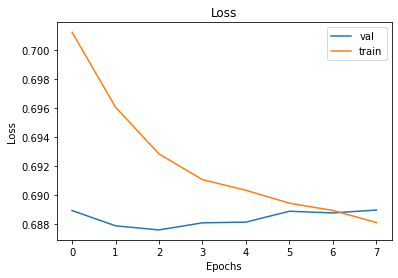

In [28]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
pred = utils.test(simple_rnn, test_iter)
pred = np.argmax(pred, axis=1)

print(accuracy_score(y_pred=pred, y_true=y_test))

0.5402298850574713


Train loss does go down, albeit it very moderately. The val acc is not good, too stable and as a result the accuracy of the model is only 54%. This is not very good in comparison with our classical algorithm.

In [30]:
sum(p.numel() for p in simple_rnn.parameters() if p.requires_grad)

505202

The model is too big, another model with less input neurons might help:

In [34]:
simple_rnn = SimpleRNN(emb_dim=10)

simple_rnn = simple_rnn.cuda()

history = utils.train(model=simple_rnn,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(simple_rnn.parameters(), lr=0.0001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=50,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 0.7036 val_cls: 0.7007 val_acc: 0.4598
tensor(0.7007) None
epoch 2 train loss: 0.7025 val_cls: 0.6996 val_acc: 0.4598
tensor(0.6996) tensor(0.7007)
epoch 3 train loss: 0.7012 val_cls: 0.6987 val_acc: 0.4598
tensor(0.6987) tensor(0.6996)
epoch 4 train loss: 0.7002 val_cls: 0.6977 val_acc: 0.4598
tensor(0.6977) tensor(0.6987)
epoch 5 train loss: 0.6993 val_cls: 0.6967 val_acc: 0.4598
tensor(0.6967) tensor(0.6977)
epoch 6 train loss: 0.6983 val_cls: 0.6959 val_acc: 0.4483
tensor(0.6959) tensor(0.6967)
epoch 7 train loss: 0.6974 val_cls: 0.6951 val_acc: 0.4483
tensor(0.6951) tensor(0.6959)
epoch 8 train loss: 0.6967 val_cls: 0.6943 val_acc: 0.4598
tensor(0.6943) tensor(0.6951)
epoch 9 train loss: 0.6959 val_cls: 0.6937 val_acc: 0.4598
tensor(0.6937) tensor(0.6943)
epoch 10 train loss: 0.6953 val_cls: 0.6930 val_acc: 0.5172
tensor(0.6930) tensor(0.6937)
epoch 11 train loss: 0.6947 val_cls: 0.6925 val_acc: 0.5402
tensor(0.6925) tensor(0.6930)
epoch 12 train loss: 0.6941 v

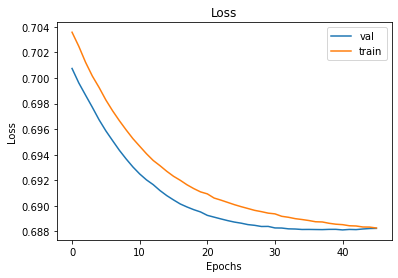

In [35]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
pred = utils.test(simple_rnn, test_iter)
pred = np.argmax(pred, axis=1)

print(accuracy_score(y_pred=pred, y_true=y_test))

0.5517241379310345


Curve is healthy, accuracy is not good however. The model is learning but  still not capable of accurately predicting the correct output.

In [37]:
simple_rnn = SimpleRNN(emb_dim=5)

simple_rnn = simple_rnn.cuda()

history = utils.train(model=simple_rnn,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(simple_rnn.parameters(), lr=0.001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=100,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 0.7323 val_cls: 0.7274 val_acc: 0.5517
tensor(0.7274) None
epoch 2 train loss: 0.7207 val_cls: 0.7180 val_acc: 0.5517
tensor(0.7180) tensor(0.7274)
epoch 3 train loss: 0.7112 val_cls: 0.7105 val_acc: 0.5517
tensor(0.7105) tensor(0.7180)
epoch 4 train loss: 0.7042 val_cls: 0.7043 val_acc: 0.5517
tensor(0.7043) tensor(0.7105)
epoch 5 train loss: 0.6988 val_cls: 0.6997 val_acc: 0.5517
tensor(0.6997) tensor(0.7043)
epoch 6 train loss: 0.6942 val_cls: 0.6967 val_acc: 0.5517
tensor(0.6967) tensor(0.6997)
epoch 7 train loss: 0.6912 val_cls: 0.6946 val_acc: 0.5517
tensor(0.6946) tensor(0.6967)
epoch 8 train loss: 0.6897 val_cls: 0.6933 val_acc: 0.5517
tensor(0.6933) tensor(0.6946)
epoch 9 train loss: 0.6884 val_cls: 0.6927 val_acc: 0.5517
tensor(0.6927) tensor(0.6933)
epoch 10 train loss: 0.6880 val_cls: 0.6923 val_acc: 0.5517
tensor(0.6923) tensor(0.6927)
epoch 11 train loss: 0.6875 val_cls: 0.6921 val_acc: 0.5517
tensor(0.6921) tensor(0.6923)
epoch 12 train loss: 0.6873 v

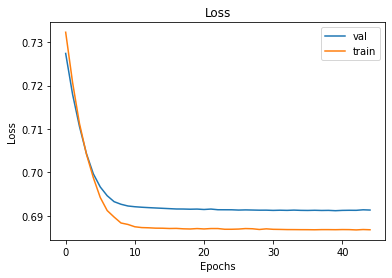

In [38]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
pred = utils.test(simple_rnn, test_iter)
pred = np.argmax(pred, axis=1)

print(accuracy_score(y_pred=pred, y_true=y_test))

0.5517241379310345


Accuracy does not improve, the curve flattens out quickly and the added epochs combined with a less severe learning rate is not beneficial. Let's try one more model, with less epochs, a high learning rate and a lower patience:

In [44]:
simple_rnn = SimpleRNN(emb_dim=20)

simple_rnn = simple_rnn.cuda()

history = utils.train(model=simple_rnn,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(simple_rnn.parameters(), lr=5e-4),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=40,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 0.6987 val_cls: 0.6899 val_acc: 0.5287
tensor(0.6899) None
epoch 2 train loss: 0.6925 val_cls: 0.6873 val_acc: 0.5517
tensor(0.6873) tensor(0.6899)
epoch 3 train loss: 0.6909 val_cls: 0.6866 val_acc: 0.5517
tensor(0.6866) tensor(0.6873)
epoch 4 train loss: 0.6904 val_cls: 0.6866 val_acc: 0.5517
tensor(0.6866) tensor(0.6866)
epoch 5 train loss: 0.6891 val_cls: 0.6872 val_acc: 0.5517
tensor(0.6872) tensor(0.6866)
epoch 6 train loss: 0.6885 val_cls: 0.6878 val_acc: 0.5517
tensor(0.6878) tensor(0.6866)
epoch 7 train loss: 0.6880 val_cls: 0.6882 val_acc: 0.5517
tensor(0.6882) tensor(0.6866)
epoch 8 train loss: 0.6880 val_cls: 0.6885 val_acc: 0.5517
tensor(0.6885) tensor(0.6866)
epoch 9 train loss: 0.6877 val_cls: 0.6891 val_acc: 0.5517
tensor(0.6891) tensor(0.6866)
EARLY STOPPING 


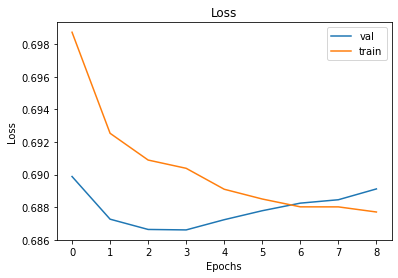

In [45]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
pred = utils.test(simple_rnn, test_iter)
pred = np.argmax(pred, axis=1)

print(accuracy_score(y_pred=pred, y_true=y_test))

0.5517241379310345


Still the same accuracy, however the model does early stop after epoch 9 here.

Simple RNN models are not great at long sequences, so to finish it is probably a good idea to run an LSTM model and see if that has any impact.

In [47]:
class LSTM(nn.Module):
  def __init__(self, emb_dim=50):
    super(LSTM, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words, 
                                   embedding_dim=emb_dim, padding_idx=0)
    
    self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=emb_dim, num_layers=1,
                      batch_first=True)
    
    self.linear_layer = nn.Linear(in_features=emb_dim, out_features=2)
    

  def forward(self, x):
    len_x = (x !=0).sum(1)


    x = self.embeddings(x)

    x = pack_padded_sequence(x, len_x.cpu(), batch_first=True, 
                             enforce_sorted=False)
    _, (x, _) = self.rnn(x)
    x = x[0]
    return self.linear_layer(x)

In [50]:
lstm = LSTM(emb_dim=50)

lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=40,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=5))

epoch 1 train loss: 0.6977 val_cls: 0.6872 val_acc: 0.5172
tensor(0.6872) None
epoch 2 train loss: 0.6916 val_cls: 0.6893 val_acc: 0.5517
tensor(0.6893) tensor(0.6872)
epoch 3 train loss: 0.6886 val_cls: 0.6893 val_acc: 0.5517
tensor(0.6893) tensor(0.6872)
epoch 4 train loss: 0.6883 val_cls: 0.6909 val_acc: 0.5402
tensor(0.6909) tensor(0.6872)
epoch 5 train loss: 0.6867 val_cls: 0.6913 val_acc: 0.5517
tensor(0.6913) tensor(0.6872)
epoch 6 train loss: 0.6865 val_cls: 0.6921 val_acc: 0.5287
tensor(0.6921) tensor(0.6872)
EARLY STOPPING 


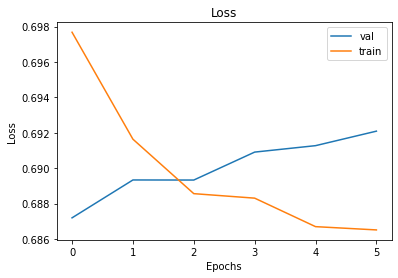

In [51]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The train data does improve but the val now ascends which is not good.

The data is by now overtrained and will not yield better results anymore. The accuracy of the model is dissapointing, the classical model does perform a lot better regarding this task.

In [56]:
lstm = LSTM(emb_dim=300)

lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.0001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=100,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=10))

epoch 1 train loss: 0.6941 val_cls: 0.6874 val_acc: 0.5402
tensor(0.6874) None
epoch 2 train loss: 0.6928 val_cls: 0.6903 val_acc: 0.5517
tensor(0.6903) tensor(0.6874)
epoch 3 train loss: 0.6898 val_cls: 0.6927 val_acc: 0.4943
tensor(0.6927) tensor(0.6874)
epoch 4 train loss: 0.6901 val_cls: 0.6905 val_acc: 0.5517
tensor(0.6905) tensor(0.6874)
epoch 5 train loss: 0.6885 val_cls: 0.6931 val_acc: 0.4943
tensor(0.6931) tensor(0.6874)
epoch 6 train loss: 0.6883 val_cls: 0.6933 val_acc: 0.4943
tensor(0.6933) tensor(0.6874)
epoch 7 train loss: 0.6874 val_cls: 0.6935 val_acc: 0.4943
tensor(0.6935) tensor(0.6874)
epoch 8 train loss: 0.6877 val_cls: 0.6924 val_acc: 0.5517
tensor(0.6924) tensor(0.6874)
epoch 9 train loss: 0.6865 val_cls: 0.6946 val_acc: 0.4943
tensor(0.6946) tensor(0.6874)
epoch 10 train loss: 0.6861 val_cls: 0.6943 val_acc: 0.5287
tensor(0.6943) tensor(0.6874)
epoch 11 train loss: 0.6866 val_cls: 0.6942 val_acc: 0.5287
tensor(0.6942) tensor(0.6874)
EARLY STOPPING 


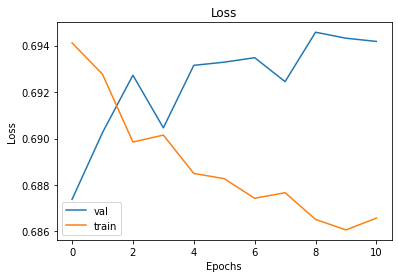

In [57]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The model is still very big, lets look at an average model and average all the input embeddings:

In [58]:
class AverageModel(nn.Module):
  def __init__(self, emb_dim=50):
    super(AverageModel, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words, 
                                   embedding_dim=emb_dim, padding_idx=0)
    
    self.layer = nn.Sequential(nn.Linear(in_features=emb_dim, out_features=emb_dim), 
                                nn.ReLU(),
                                nn.Linear(in_features=emb_dim, out_features=2))
    

  def forward(self, x):
    # later we are going to mask zeros in the input to calculate average
    mask = x != 0
    x = self.embeddings(x)
    x = x.sum(dim=1)/mask.sum(dim=1,  keepdim=True)
    return self.layer(x)

In [59]:
average_model = AverageModel(emb_dim=300)

average_model = average_model.cuda()

history = utils.train(model=average_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(average_model.parameters(), lr=0.0001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.7175 val_cls: 0.6998 val_acc: 0.5517
tensor(0.6998) None
epoch 2 train loss: 0.6958 val_cls: 0.6892 val_acc: 0.5517
tensor(0.6892) tensor(0.6998)
epoch 3 train loss: 0.6877 val_cls: 0.6910 val_acc: 0.5517
tensor(0.6910) tensor(0.6892)
epoch 4 train loss: 0.6898 val_cls: 0.6878 val_acc: 0.5517
tensor(0.6878) tensor(0.6892)
epoch 5 train loss: 0.6888 val_cls: 0.6881 val_acc: 0.5517
tensor(0.6881) tensor(0.6878)
epoch 6 train loss: 0.6897 val_cls: 0.6887 val_acc: 0.5517
tensor(0.6887) tensor(0.6878)
epoch 7 train loss: 0.6893 val_cls: 0.6888 val_acc: 0.5517
tensor(0.6888) tensor(0.6878)
EARLY STOPPING 


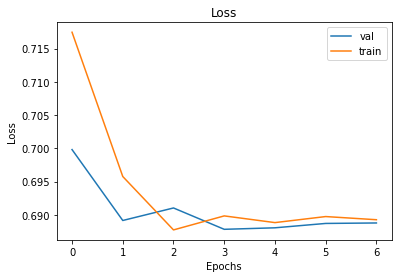

In [60]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
average_model = AverageModel(emb_dim=20)

average_model = average_model.cuda()

history = utils.train(model=average_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc}, 
              optimizer=torch.optim.Adam(average_model.parameters(), lr=0.0001),
              train_ds=train_iter, 
              dev_ds=dev_iter,
              num_epochs=40,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.7269 val_cls: 0.7237 val_acc: 0.4483
tensor(0.7237) None
epoch 2 train loss: 0.7205 val_cls: 0.7176 val_acc: 0.4483
tensor(0.7176) tensor(0.7237)
epoch 3 train loss: 0.7145 val_cls: 0.7125 val_acc: 0.4483
tensor(0.7125) tensor(0.7176)
epoch 4 train loss: 0.7101 val_cls: 0.7076 val_acc: 0.4483
tensor(0.7076) tensor(0.7125)
epoch 5 train loss: 0.7059 val_cls: 0.7037 val_acc: 0.4483
tensor(0.7037) tensor(0.7076)
epoch 6 train loss: 0.7024 val_cls: 0.7004 val_acc: 0.4483
tensor(0.7004) tensor(0.7037)
epoch 7 train loss: 0.6991 val_cls: 0.6981 val_acc: 0.4483
tensor(0.6981) tensor(0.7004)
epoch 8 train loss: 0.6970 val_cls: 0.6958 val_acc: 0.4483
tensor(0.6958) tensor(0.6981)
epoch 9 train loss: 0.6949 val_cls: 0.6941 val_acc: 0.4483
tensor(0.6941) tensor(0.6958)
epoch 10 train loss: 0.6935 val_cls: 0.6926 val_acc: 0.5517
tensor(0.6926) tensor(0.6941)
epoch 11 train loss: 0.6922 val_cls: 0.6915 val_acc: 0.5517
tensor(0.6915) tensor(0.6926)
epoch 12 train loss: 0.6913 v

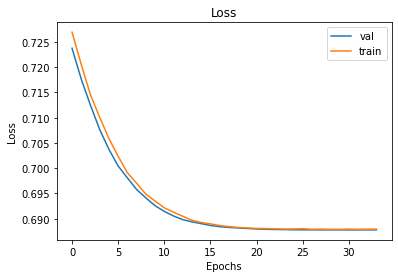

In [63]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
pred = utils.test(average_model, test_iter)
pred = np.argmax(pred, axis=1)

print(accuracy_score(y_pred=pred, y_true=y_test))

0.5517241379310345


Accuracy does not improve although the curve is good. The model in comparison to its baseline is not as good and not usable as a result for this task.